In [1]:
import torch
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import matplotlib
import matplotlib.pyplot as plt
from torchvision.datasets import MNIST
from torchvision.transforms import ToTensor
from torchvision.utils import make_grid
from torch.utils.data import DataLoader
from torch.utils.data import random_split



In [2]:
# creating dataset 

dataset = MNIST(root = "data/",
               download="True",
               transform = ToTensor())

torch.Size([1, 28, 28])
Label: 9


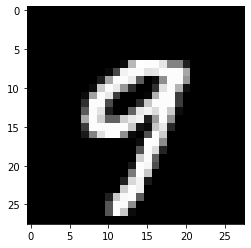

In [3]:
image , label  = dataset[45]
print(image.shape)
print("Label: {}".format(label))
plt.imshow(image.permute(1,2,0), cmap = "gray");

In [4]:
type(label)

int

Label:  1


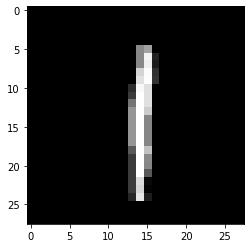

In [8]:
image , label = dataset[454]

print("Label: ", label)
plt.imshow(image.permute(1,2,0), cmap= "gray")

In [9]:
len(dataset)

60000

In [6]:
val_size = 10000
train_size = len(dataset) - val_size
train_ds , val_ds = random_split(dataset, [train_size, val_size])
len(train_ds) , len(val_ds)

(50000, 10000)

In [7]:
batch_size = 128

train_dl = DataLoader(train_ds, batch_size, shuffle = True, num_workers = 2, pin_memory = True)
val_dl = DataLoader(val_ds, batch_size*2, num_workers = 2, pin_memory = True)

Images shape :  torch.Size([128, 1, 28, 28])


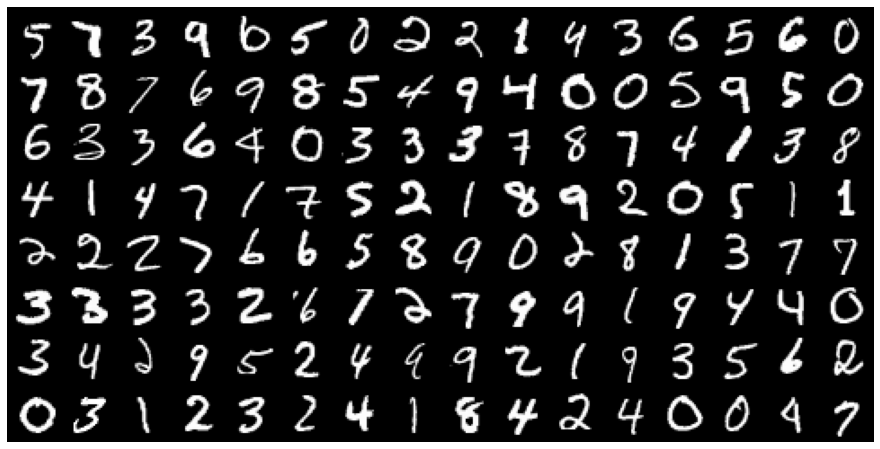

In [12]:
for images , _ in train_dl:
    print("Images shape : ", images.shape)
    plt.figure(figsize = (16,8))
    plt.axis("off")
    plt.imshow(make_grid(images, nrow = 16).permute(1,2,0));
    break

In [8]:
for images, labels in train_dl:
    print("images.shape",images.shape)
    inputs = images.reshape(images.shape[0], -1)
    print("label type : ", type(labels))
    print("Input.shape : ", inputs.shape)
    break

images.shape torch.Size([128, 1, 28, 28])
label type :  <class 'torch.Tensor'>
Input.shape :  torch.Size([128, 784])


In [14]:
inputs.shape

torch.Size([128, 784])

In [15]:
inputs.shape[-1]

784

In [16]:
input_size = inputs.shape[-1]
hidden_size = 32

In [17]:
layer_1 = nn.Linear(input_size, hidden_size)

In [18]:
layer_1_outputs = layer_1(inputs)
print("layer 1 output shape  : ",layer_1_outputs.shape )

layer 1 output shape  :  torch.Size([128, 32])


In [19]:
list(layer_1.parameters())

[Parameter containing:
 tensor([[ 0.0199, -0.0295, -0.0062,  ..., -0.0056,  0.0016,  0.0226],
         [ 0.0138,  0.0226, -0.0097,  ...,  0.0057, -0.0345, -0.0045],
         [-0.0096, -0.0064,  0.0117,  ...,  0.0127,  0.0047,  0.0101],
         ...,
         [-0.0107,  0.0355, -0.0241,  ...,  0.0095,  0.0024, -0.0064],
         [ 0.0321, -0.0259, -0.0177,  ..., -0.0037, -0.0327,  0.0243],
         [ 0.0194,  0.0145, -0.0026,  ..., -0.0229, -0.0249,  0.0147]],
        requires_grad=True),
 Parameter containing:
 tensor([-0.0011,  0.0008,  0.0295,  0.0306, -0.0286,  0.0295,  0.0060,  0.0235,
          0.0301, -0.0350,  0.0304,  0.0345, -0.0090, -0.0208,  0.0260, -0.0190,
         -0.0018,  0.0340,  0.0041, -0.0118,  0.0276,  0.0220,  0.0209, -0.0107,
          0.0289, -0.0023, -0.0280,  0.0263, -0.0170,  0.0233, -0.0061,  0.0266],
        requires_grad=True)]

In [20]:
layer_1.weight.shape

torch.Size([32, 784])

In [21]:
layer_1.bias.shape

torch.Size([32])

In [22]:
layer_1_outputs_direct = inputs @ layer_1.weight.t() + layer_1.bias
layer_1_outputs_direct.shape

torch.Size([128, 32])

In [23]:
torch.allclose(layer_1_outputs,layer_1_outputs_direct,1e-3)

True

## adding non linear functionality to the intermediate function . 

In [24]:
F.relu(torch.tensor([
    [1,-44,5],
    [3,44,-22]
]))

tensor([[ 1,  0,  5],
        [ 3, 44,  0]])

*relu()* adds non linear functionality to our model. whenever it comes across a negative value, it makes it zero *0*

In [25]:
relu_outputs = F.relu(layer_1_outputs)
print("min layer_1 outputs : ", torch.min(layer_1_outputs).item())
print("relu min outputs : ", torch.min(relu_outputs).item())

min layer_1 outputs :  -0.7157717943191528
relu min outputs :  0.0


In [26]:
output_size = 10

layer_2 = nn.Linear(hidden_size, output_size)

In [27]:
layer_2_outputs = layer_2(relu_outputs)
print("hidden_layer_output_shape: ", layer_1_outputs.shape)
print("layer 2 outputs : ", layer_2_outputs.shape)

hidden_layer_output_shape:  torch.Size([128, 32])
layer 2 outputs :  torch.Size([128, 10])


In [28]:
F.cross_entropy(layer_2_outputs, labels)

tensor(2.3010, grad_fn=<NllLossBackward>)

In [29]:
class MnistModel(nn.Module):
    
    def __init__(self, in_size, hidden_size, out_size):
        super().__init__()
        
        self.linear_1 = nn.Linear(in_size, hidden_size)
        
        self.linear_2 = nn.Linear(hidden_size, out_size)
        
    def forward(self, xb):
        xb = xb.view(xb.shape[0], -1)
        
        out = self.linear_1(xb)
        
        out = F.relu(out)
        
        out = self.linear_2(out)
        return out
    
    
    def training_step(self, batch):
    
        images, labels = batch

        outputs = self(images)

        loss = F.cross_entropy(outputs, labels)

        return loss
    
    def valid_step(self, batch):
        images , labels = batch 
        outputs = self(images)
        
        acc  = accuracy(outputs, labels)
        loss = F.cross_entropy(outputs, labels)
        
        return {"val_acc": acc, "val_loss" : loss}
    
    def valid_epoch_end(self, outputs):
        
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()
        
        batch_acc = [x["val_acc"] for x in outputs]
        epoch_acc = torch.stack(batch_acc).mean()
        
        return {"val_acc": epoch_acc.item(), "val_loss": epoch_loss.item()}
    
    def epoch_end(self, epoch, result):
        print(f"Epoch {epoch} , val_loss :  {result['val_loss']:.2f}  , val_acc: {result['val_acc']:.2f} ")
        
#     def epoch_end(self, epoch, result):
#         print("Epoch [{}], val_loss: {:.4f}, val_acc: {:.4f}".format(epoch, result['val_loss'], result['val_acc']))
    
    

In [30]:
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim = 1)
    
    return torch.tensor(torch.sum(preds == labels)/len(preds))

In [31]:
def evalute(model, valid_dl):
    outputs = [model.valid_step(batch) for batch in valid_dl]
    return model.valid_epoch_end(outputs)

In [32]:
from tqdm import tqdm
def fit(num_epoch, model, train_dl, valid_dl, lr, opt_func= torch.optim.SGD):
    optimizer = opt_func(model.parameters(), lr)
    
    history = []
    
    for epoch in tqdm(range(num_epoch)):
        
        
        # training step 
        
        for batch in train_dl : 
            loss = model.training_step(batch)
            
            loss.backward()
            
            optimizer.step()
            optimizer.zero_grad()
            
        # validation step 
        
        result = evalute(model, valid_dl)
        model.epoch_end(epoch, result)
        history.append(result)
        
    
    return history 
        
        
            

# Trainning on a gpu 

In [33]:
torch.cuda.is_available()

True

In [34]:
def get_default_device():
    
    if torch.cuda.is_available(): 
        return torch.device("cuda")
    else: 
        return torch.device("cpu")

In [35]:
device = get_default_device()
device

device(type='cuda')

In [36]:
def to_device(data, device):
    
    if isinstance(data, (list, tuple)):
        return [to_device(x, device) for x in data]
    
    return data.to(device , non_blocking = True)

In [37]:
l = (33,88)

isinstance(l, (list,tuple))

True

In [38]:
for images , labels in train_dl:
    
    print(images.shape)
    
    images = to_device(images, device)
    
    print(images.device)
    
    break

torch.Size([128, 1, 28, 28])
cuda:0


In [39]:
class DeviceDataLoader():
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        
        for b in self.dl:
            yield to_device(b, self.device)
            
    def __len__(self):
        
        return (len(self.dl))

In [40]:
# taking the existing data loaders to the gpu device 

train_loader = DeviceDataLoader(train_dl, device)
val_loader = DeviceDataLoader(val_dl, device)

In [41]:
for xb, yb in val_loader:
    print(yb.shape)
    print(yb.device)
    break

torch.Size([256])
cuda:0


In [42]:
model = MnistModel(input_size,hidden_size,output_size)
to_device(model, device)

MnistModel(
  (linear_1): Linear(in_features=784, out_features=32, bias=True)
  (linear_2): Linear(in_features=32, out_features=10, bias=True)
)

In [43]:
list(model.parameters())

[Parameter containing:
 tensor([[ 0.0032, -0.0335,  0.0269,  ...,  0.0287, -0.0231, -0.0099],
         [-0.0149,  0.0272, -0.0115,  ..., -0.0307,  0.0262,  0.0314],
         [ 0.0325, -0.0054, -0.0345,  ...,  0.0204, -0.0064, -0.0202],
         ...,
         [-0.0025, -0.0096,  0.0234,  ..., -0.0198,  0.0330, -0.0129],
         [ 0.0007,  0.0067, -0.0232,  ...,  0.0334, -0.0144, -0.0035],
         [ 0.0120,  0.0264,  0.0220,  ..., -0.0152, -0.0182,  0.0306]],
        device='cuda:0', requires_grad=True),
 Parameter containing:
 tensor([-0.0169,  0.0038,  0.0027,  0.0265, -0.0231, -0.0219,  0.0352, -0.0207,
          0.0048,  0.0288,  0.0045, -0.0006,  0.0138, -0.0232, -0.0236, -0.0009,
          0.0208,  0.0044, -0.0040,  0.0194, -0.0233, -0.0172, -0.0113, -0.0068,
          0.0185, -0.0003, -0.0034,  0.0237, -0.0129, -0.0308,  0.0057, -0.0232],
        device='cuda:0', requires_grad=True),
 Parameter containing:
 tensor([[ 0.0655, -0.0571,  0.0591,  0.1308,  0.0877,  0.1217, -0.0398, 

In [44]:
model.linear_1.weight.shape

torch.Size([32, 784])

In [45]:
model.linear_2.weight.shape

torch.Size([10, 32])

In [46]:
history = [evalute(model, val_loader)]
history

<ipython-input-30-5aca127ab2a2>:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(torch.sum(preds == labels)/len(preds))


[{'val_acc': 0.10703124850988388, 'val_loss': 2.3044400215148926}]

In [47]:
history+=fit(5,model,train_loader, val_loader,0.5)

  0%|                                                    | 0/5 [00:00<?, ?it/s]<ipython-input-30-5aca127ab2a2>:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(torch.sum(preds == labels)/len(preds))
 20%|████████▊                                   | 1/5 [00:15<01:03, 15.78s/it]

Epoch 0 , val_loss :  0.23  , val_acc: 0.93 


 40%|█████████████████▌                          | 2/5 [00:24<00:35, 11.72s/it]

Epoch 1 , val_loss :  0.18  , val_acc: 0.94 


 60%|██████████████████████████▍                 | 3/5 [00:35<00:22, 11.25s/it]

Epoch 2 , val_loss :  0.15  , val_acc: 0.95 


 80%|███████████████████████████████████▏        | 4/5 [00:45<00:10, 10.64s/it]

Epoch 3 , val_loss :  0.15  , val_acc: 0.95 


100%|████████████████████████████████████████████| 5/5 [00:54<00:00, 10.98s/it]

Epoch 4 , val_loss :  0.12  , val_acc: 0.96 


In [48]:
history+=fit(5, model, train_loader, val_loader, 0.3)

  0%|                                                    | 0/5 [00:00<?, ?it/s]<ipython-input-30-5aca127ab2a2>:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(torch.sum(preds == labels)/len(preds))
 20%|████████▊                                   | 1/5 [00:10<00:43, 10.96s/it]

Epoch 0 , val_loss :  0.12  , val_acc: 0.96 


 40%|█████████████████▌                          | 2/5 [00:23<00:35, 11.72s/it]

Epoch 1 , val_loss :  0.11  , val_acc: 0.97 


 60%|██████████████████████████▍                 | 3/5 [00:34<00:22, 11.40s/it]

Epoch 2 , val_loss :  0.11  , val_acc: 0.97 


 80%|███████████████████████████████████▏        | 4/5 [00:47<00:12, 12.10s/it]

Epoch 3 , val_loss :  0.11  , val_acc: 0.97 


100%|████████████████████████████████████████████| 5/5 [00:59<00:00, 11.87s/it]

Epoch 4 , val_loss :  0.11  , val_acc: 0.97 


In [49]:
history += fit(5, model, train_loader, val_loader, 0.1)

  0%|                                                    | 0/5 [00:00<?, ?it/s]<ipython-input-30-5aca127ab2a2>:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(torch.sum(preds == labels)/len(preds))
 20%|████████▊                                   | 1/5 [00:10<00:42, 10.74s/it]

Epoch 0 , val_loss :  0.10  , val_acc: 0.97 


 40%|█████████████████▌                          | 2/5 [00:23<00:36, 12.13s/it]

Epoch 1 , val_loss :  0.10  , val_acc: 0.97 


 60%|██████████████████████████▍                 | 3/5 [00:38<00:26, 13.23s/it]

Epoch 2 , val_loss :  0.10  , val_acc: 0.97 


 80%|███████████████████████████████████▏        | 4/5 [00:52<00:13, 13.62s/it]

Epoch 3 , val_loss :  0.10  , val_acc: 0.97 


100%|████████████████████████████████████████████| 5/5 [01:06<00:00, 13.36s/it]

Epoch 4 , val_loss :  0.10  , val_acc: 0.97 


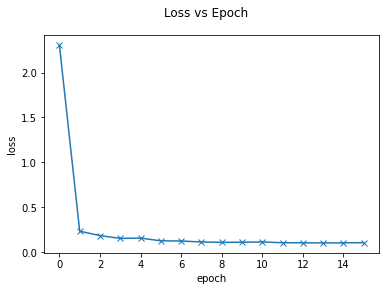

In [50]:
losses = [x['val_loss'] for x in history ]
plt.plot(losses, '-x')
plt.xlabel("epoch")
plt.ylabel("loss")
plt.suptitle("Loss vs Epoch")
plt.show()


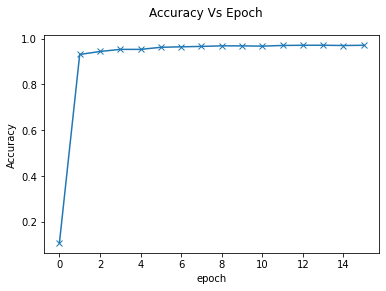

In [51]:
accuracies = [x["val_acc"] for x in history]
plt.plot(accuracies, '-x')
plt.xlabel("epoch")
plt.ylabel("Accuracy")
plt.suptitle("Accuracy Vs Epoch")
plt.show()

## Testing with individual Images 

In [52]:
test_dataset = MNIST(root = "data/",
                     train = False,
                     transform = ToTensor())

In [54]:
image, label = test_dataset[0]

xb = to_device(image.unsqueeze(0), device)
print(image.shape)
print(xb.shape)

torch.Size([1, 28, 28])
torch.Size([1, 1, 28, 28])


In [55]:
yb = model(xb)
print(yb)
_, preds = torch.max(yb, dim = 1)
print(preds)

tensor([[ -3.1368,  -3.8146,   3.2148,   7.2331, -13.1787,   1.1990, -13.1033,
          14.8186,   1.3061,   3.2715]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([7], device='cuda:0')


In [56]:
def predict_image_digit(model, image):
    xb = to_device(image.unsqueeze(0), device)
    yb = model(xb)
    
    _ , preds = torch.max(yb, dim = 1)
    return (preds[0].item())

Image label 5 	 Predicted Label : 5


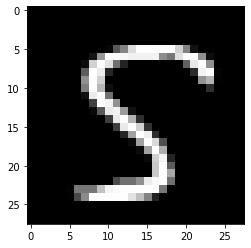

In [58]:
image , label = test_dataset[333]

plt.imshow(image.permute(1,2,0), cmap = "gray");
print(f"Image label {label} \t Predicted Label : {predict_image_digit(model, image)}")


Image label 9 	 Predicted Label : 9


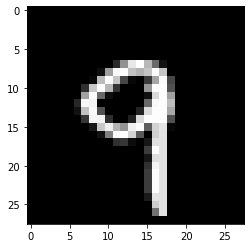

In [59]:
image , label = test_dataset[773]

plt.imshow(image.permute(1,2,0), cmap = "gray");
print(f"Image label {label} \t Predicted Label : {predict_image_digit(model, image)}")

In [ ]:
image , label = train_dataset[373]

plt.imshow(image.permute(1,2,0), cmap = "gray");
print(f"Image label {label} \t Predicted Label : {predict_image_digit(model, image)}")

In [ ]:
image , label = train_dataset[73]

plt.imshow(image.permute(1,2,0), cmap = "gray");
print(f"Image label {label} \t Predicted Label : {predict_image_digit(model, image)}")

In [ ]:
test_loader = DeviceDataLoader(DataLoader(test_dataset,256), device)

In [ ]:
result = evalute(model, test_loader)
result

# saving the model 

In [ ]:
torch.save(model.state_dict(),"mnist-feedforward.pth")

## loading a existing model 

In [ ]:
model.state_dict()

In [ ]:
model_2 = MnistModel(784,32,10)


In [ ]:
model_2.state_dict()

In [ ]:
before_loading = evalute(model_2, DataLoader(test_dataset, 256))
before loading

##### loading the model's state into model 2

In [ ]:
model_2.load_state_dict(torch.load("mnist-feedforward.pth"))

In [ ]:
model_2.linear_1.weight.shape

In [ ]:
after_loading = evalute(model_2,DataLoader(test_dataset, 256) )
after_loading